In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms, utils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
%matplotlib inline

In [2]:
def load_labels(file_path):

    labels_dict = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            
            key, value = line.split(':')  
            
            labels_dict[key] = value
    
    return labels_dict

In [3]:
def load_and_preprocess(img_pth, plot=True, transform=True):
    image = Image.open(str('panda.jpg'))
    if plot:
        plt.imshow(image)
        plt.show()
    
    if transform:
        transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0., std=1.)
        ])
    
    return transform(image).unsqueeze(0).to("cuda")


In [4]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.to("cuda")
model.eval()

/home/mohamed/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mohamed/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
def extract_conv_layers(model):
    conv_layers = []
    model_children = list(model.children())
    counter = 0

    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv2d:
            counter+=1
            conv_layers.append(model_children[i])
        elif type(model_children[i]) == nn.Sequential:
            for j in range(len(model_children[i])):
                for child in model_children[i][j].children():
                    if type(child) == nn.Conv2d:
                        counter+=1
                        conv_layers.append(child)
    
    return conv_layers

In [6]:
def get_activations(conv_layers, image):
    outputs = []
    for layer in conv_layers[0:]:
        image = layer(image)
        outputs.append(image)
    
    return outputs


In [7]:
def summarize_channels(outputs):
    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())

    return processed


In [8]:
def plot(processed_feaeture_maps):
    fig = plt.figure(figsize=(30, 20))
    for i in range(len(processed_feaeture_maps)):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(processed_feaeture_maps[i])
        a.axis("off")


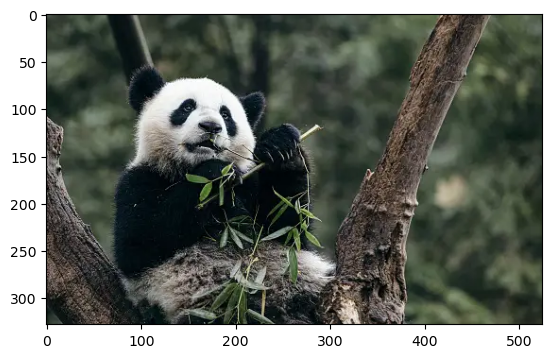

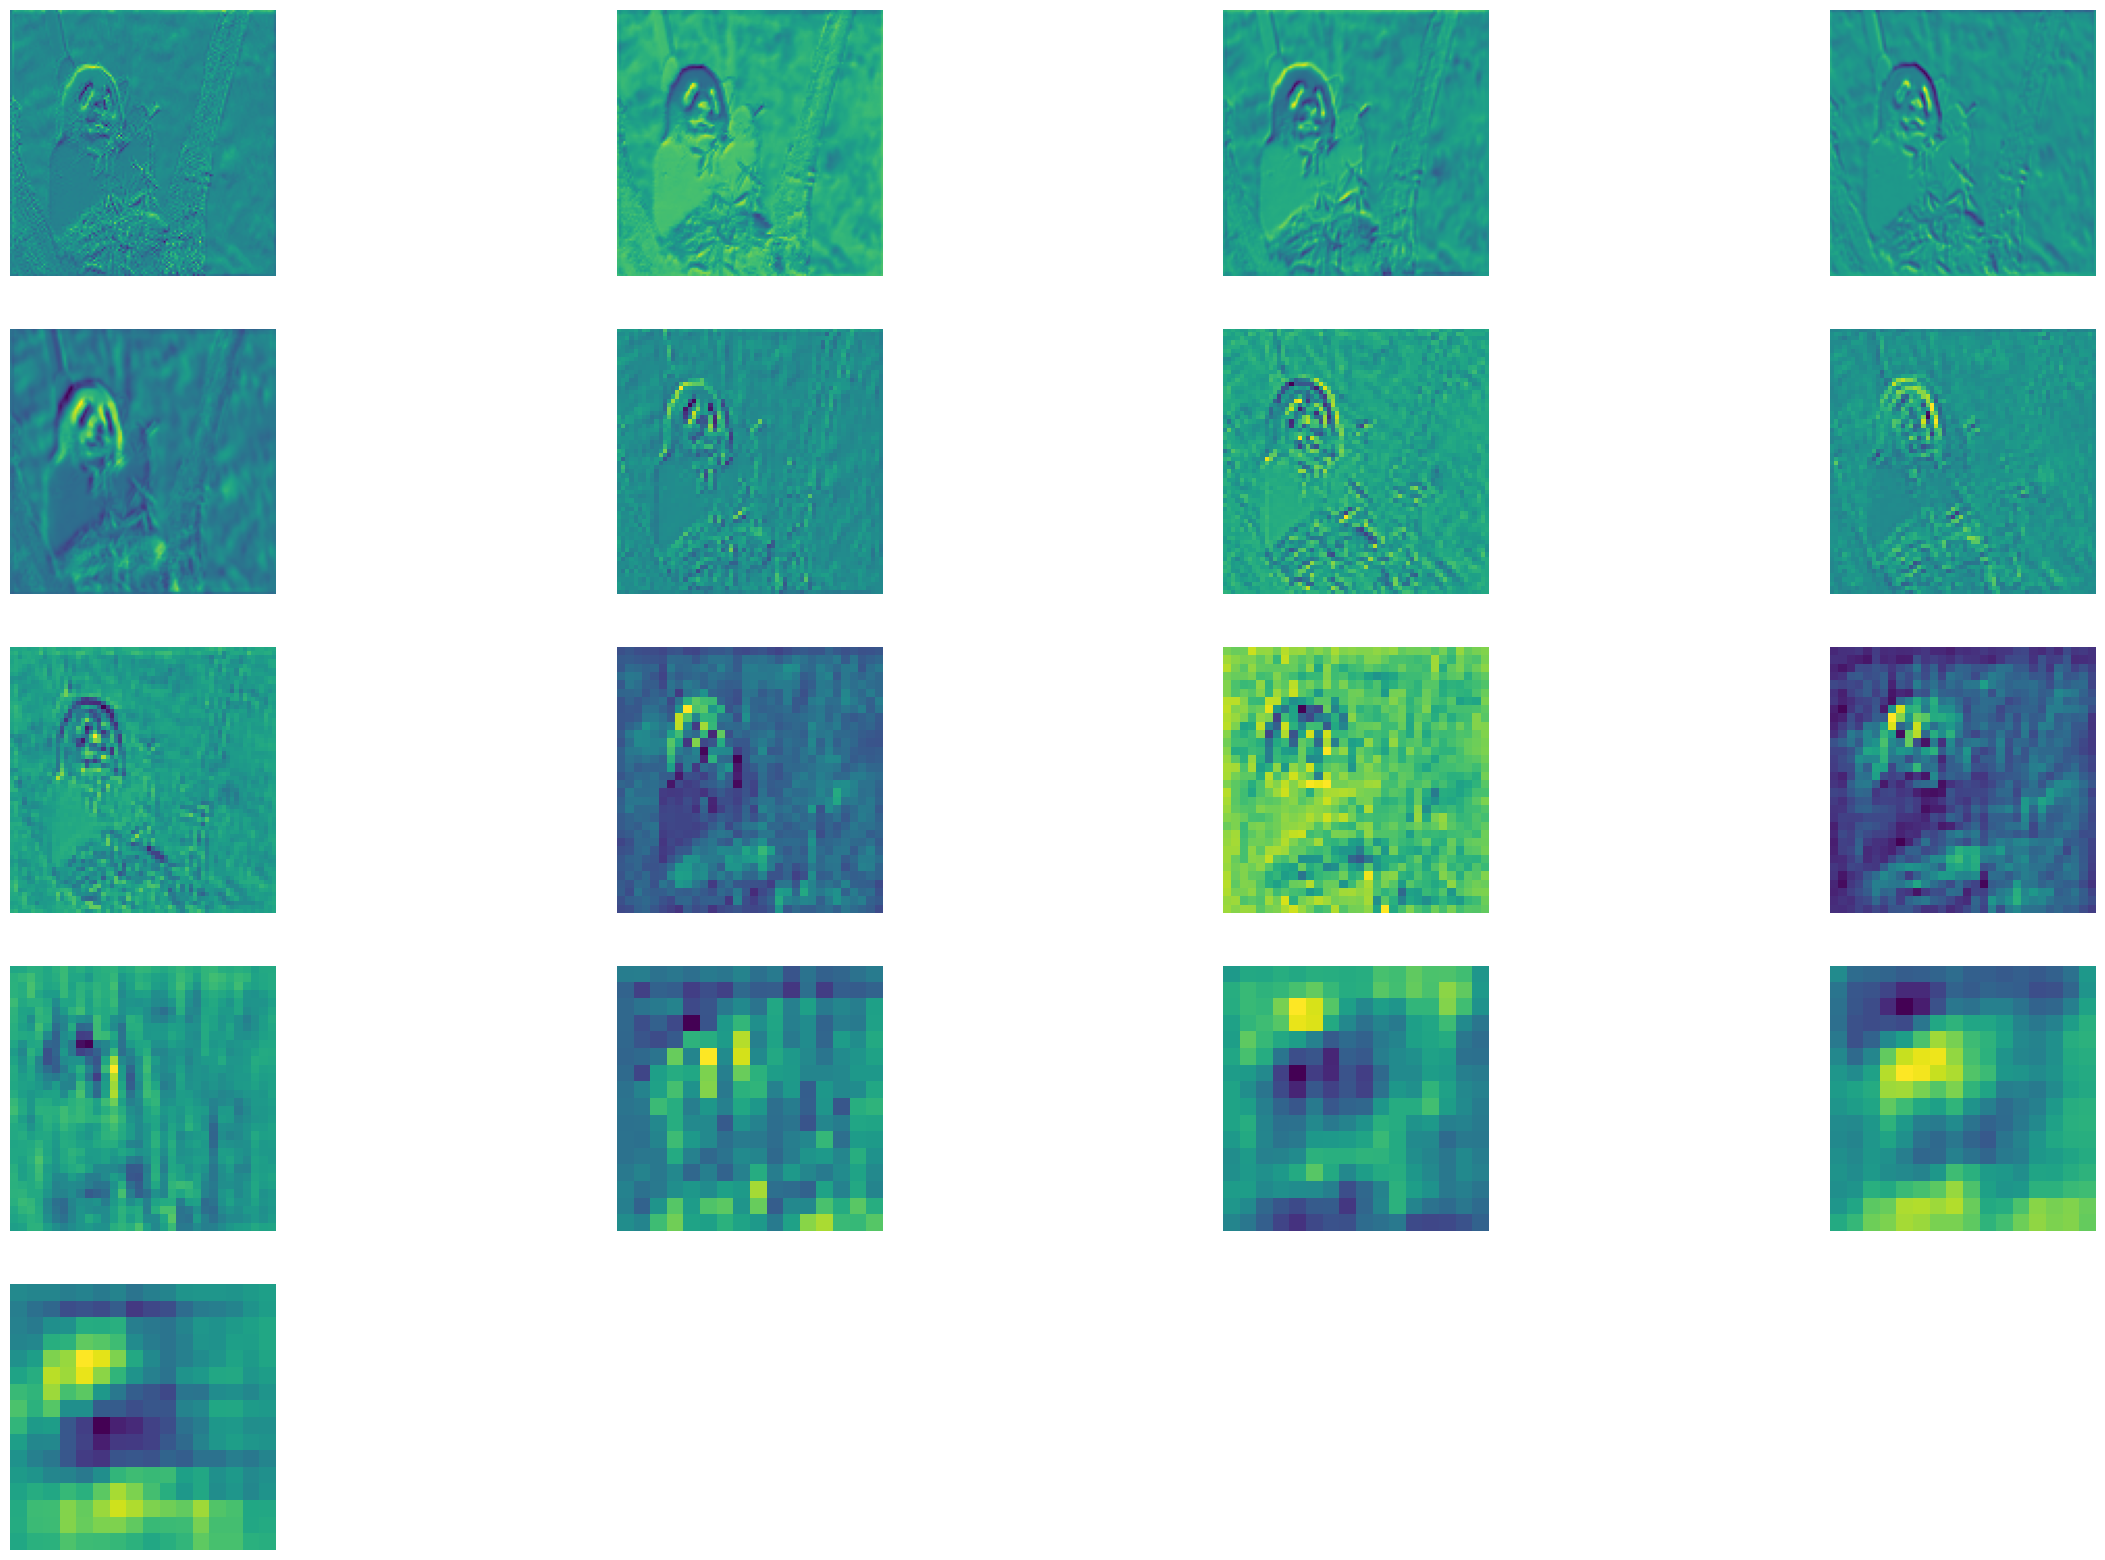

In [9]:
conv_layers = extract_conv_layers(model=model)
outputs  = get_activations(conv_layers=conv_layers, image=load_and_preprocess(img_pth='panda.jpg'))
processed_feature_maps = summarize_channels(outputs=outputs)
plot(processed_feature_maps)

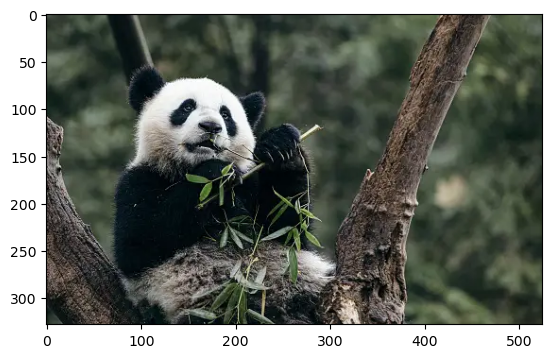

prediction is  'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca',


In [10]:
image = load_and_preprocess(img_pth='panda.jpg')
ItoS = load_labels(file_path='labels.txt')
print(f"prediction is { ItoS[str(torch.argmax(model(image)).item())]}")

In [11]:
from FGSM import fgsm_attack

In [12]:
import torch
import torch.nn.functional as F

def run_attack(model, x_adv, epsilon, n_iter, target_label):
    x_a = x_adv.clone().detach()
    x_a.requires_grad = True
    x_a.retain_grad()

    for _ in range(n_iter):
        out = model(x_a)
        # Ensure target_label is on the same device as your model and inputs
        target = torch.tensor([target_label], dtype=torch.long, device=x_a.device)
        loss = F.nll_loss(out, target)

        model.zero_grad()  # Zero out gradients for the model
        loss.backward()    # Backpropagate to compute gradients

        data_grad = x_a.grad.data

        # Ensure fgsm_attack is properly defined
        perturbed_data = fgsm_attack(x_a, epsilon, data_grad)

        x_a = perturbed_data.detach().requires_grad_(True)
        x_a.retain_grad()

    return x_a


In [13]:
adv_imgs=[]

for eps in [64/255, 32/255, 16/255, 8/255, 4/255, 2/255]:
    adv_img = run_attack(model, image, eps, 1, 20)
    adv_imgs.append(adv_img)

epsilon: 0.00784313725490196, prediction:  'gibbon, Hylobates lar',


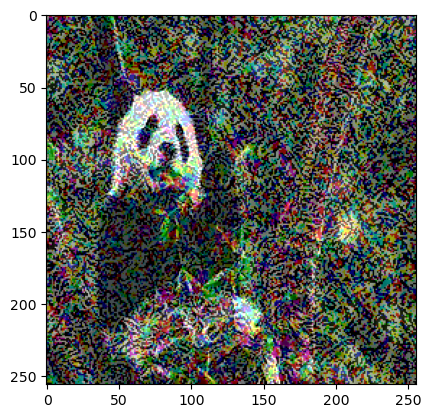

epsilon: 0.00784313725490196, prediction:  'gibbon, Hylobates lar',


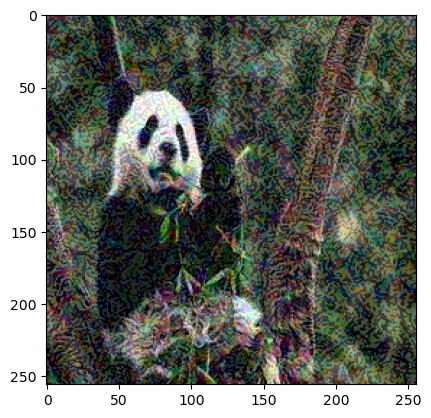

epsilon: 0.00784313725490196, prediction:  'gibbon, Hylobates lar',


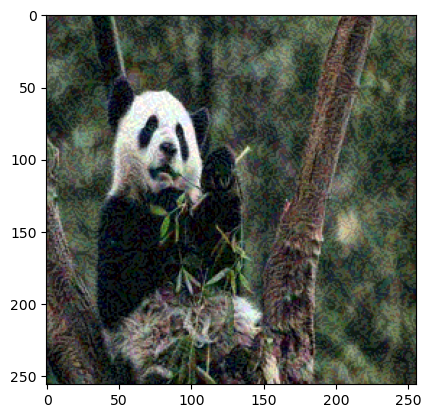

epsilon: 0.00784313725490196, prediction:  'gibbon, Hylobates lar',


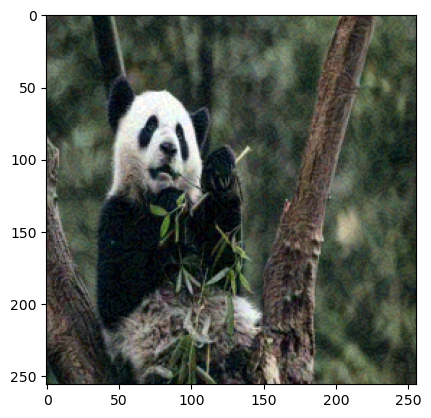

epsilon: 0.00784313725490196, prediction:  'gibbon, Hylobates lar',


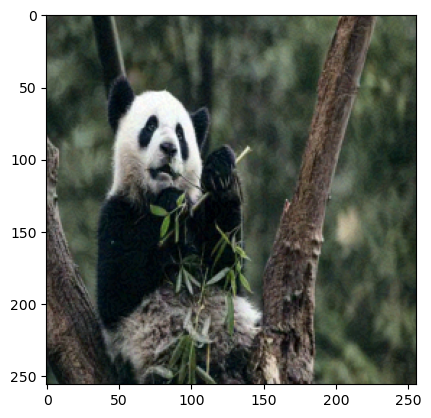

epsilon: 0.00784313725490196, prediction:  'gibbon, Hylobates lar',


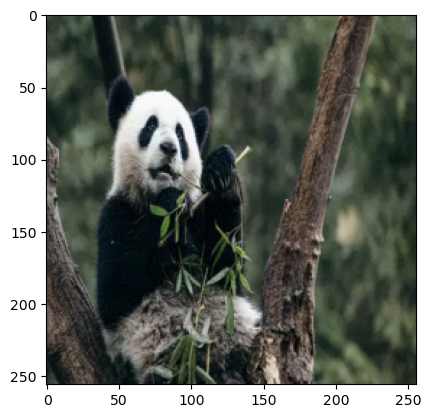

In [14]:
for i, adv_im in enumerate(adv_imgs):
    idx = torch.argmax(model(adv_img)).item()
    print(f"epsilon: {eps}, prediction: {ItoS[str(idx)]}")
    plt.imshow(adv_im.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    plt.show()


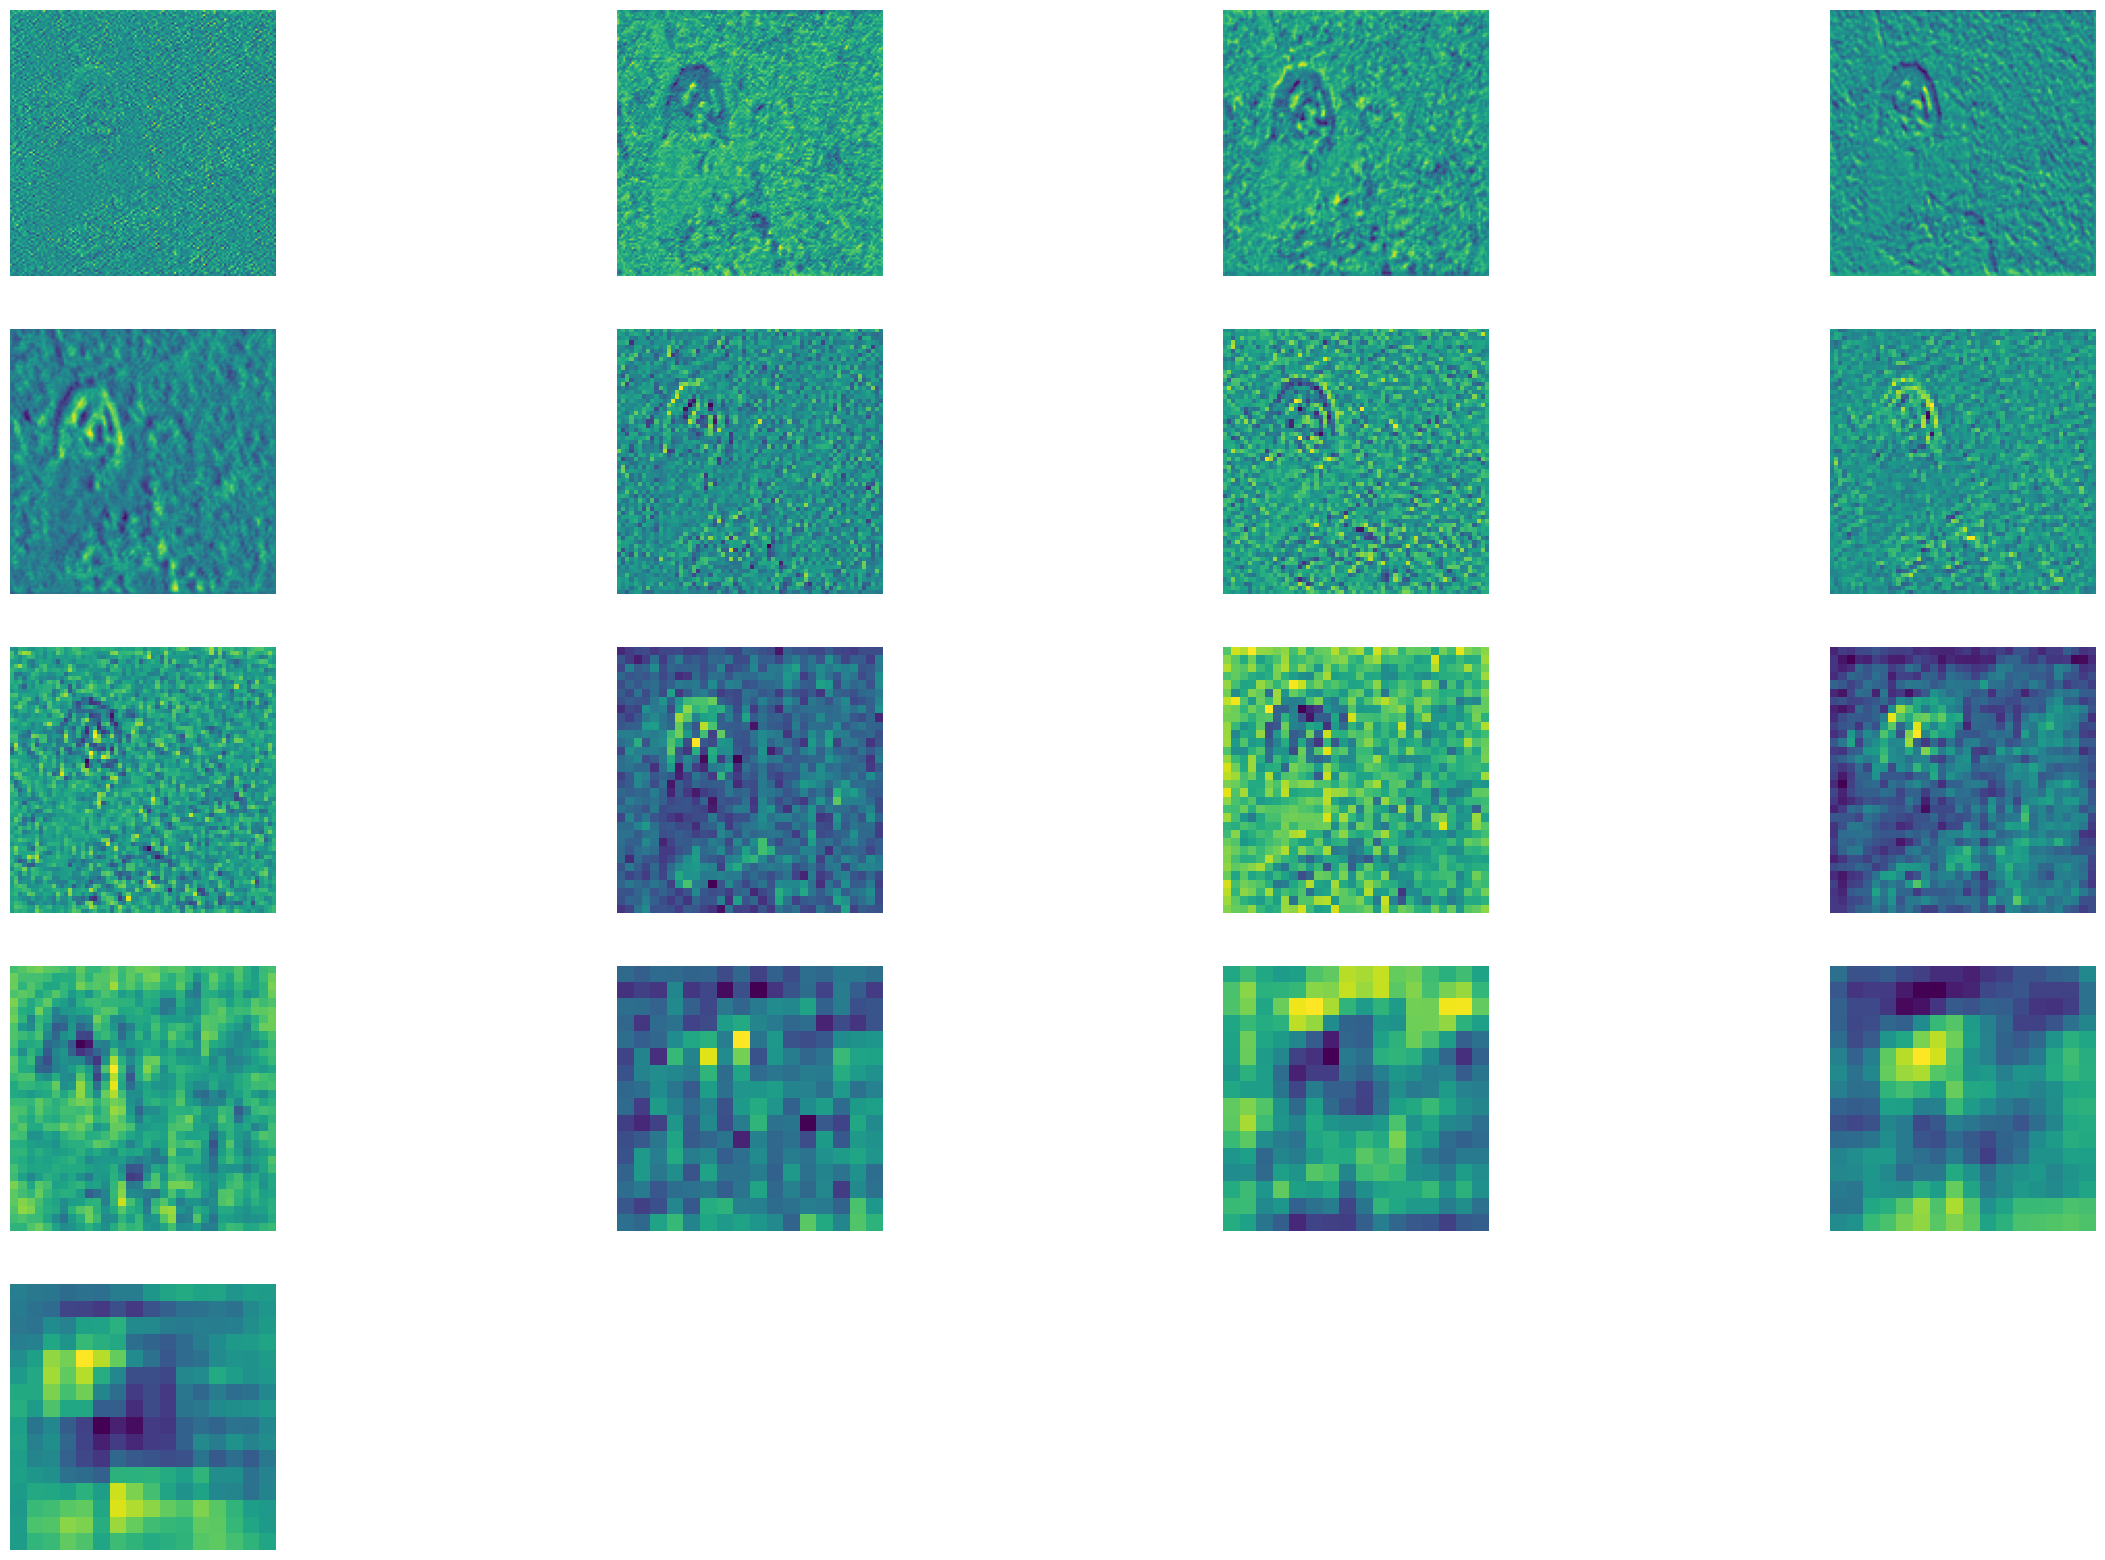

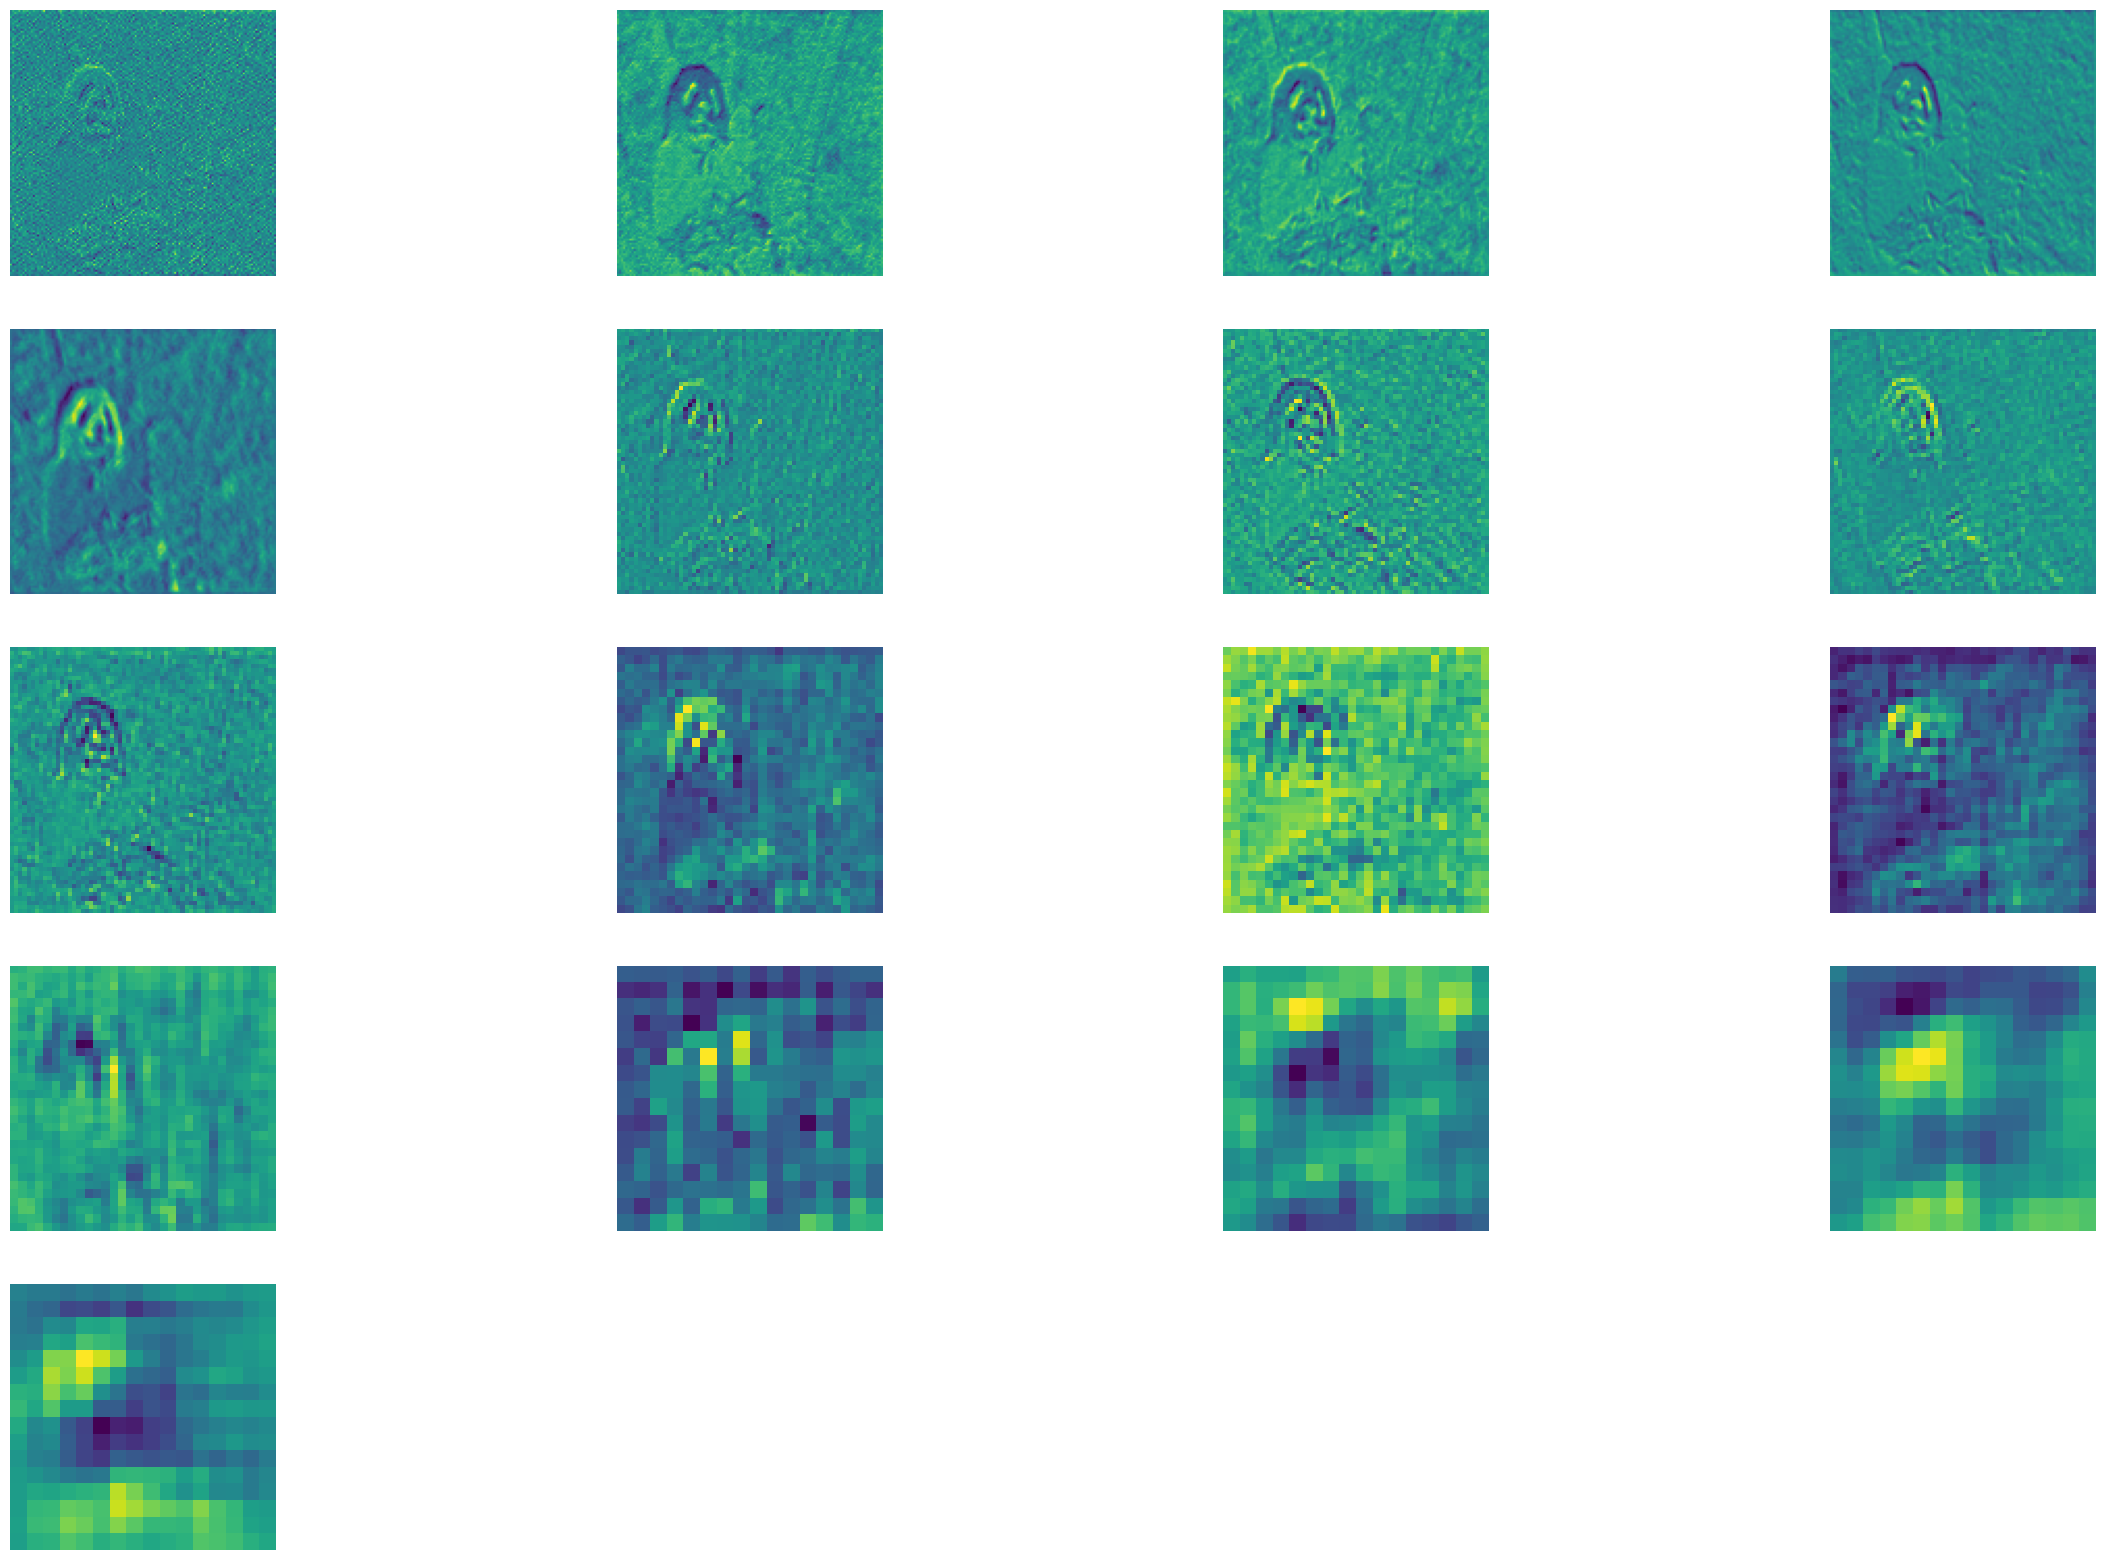

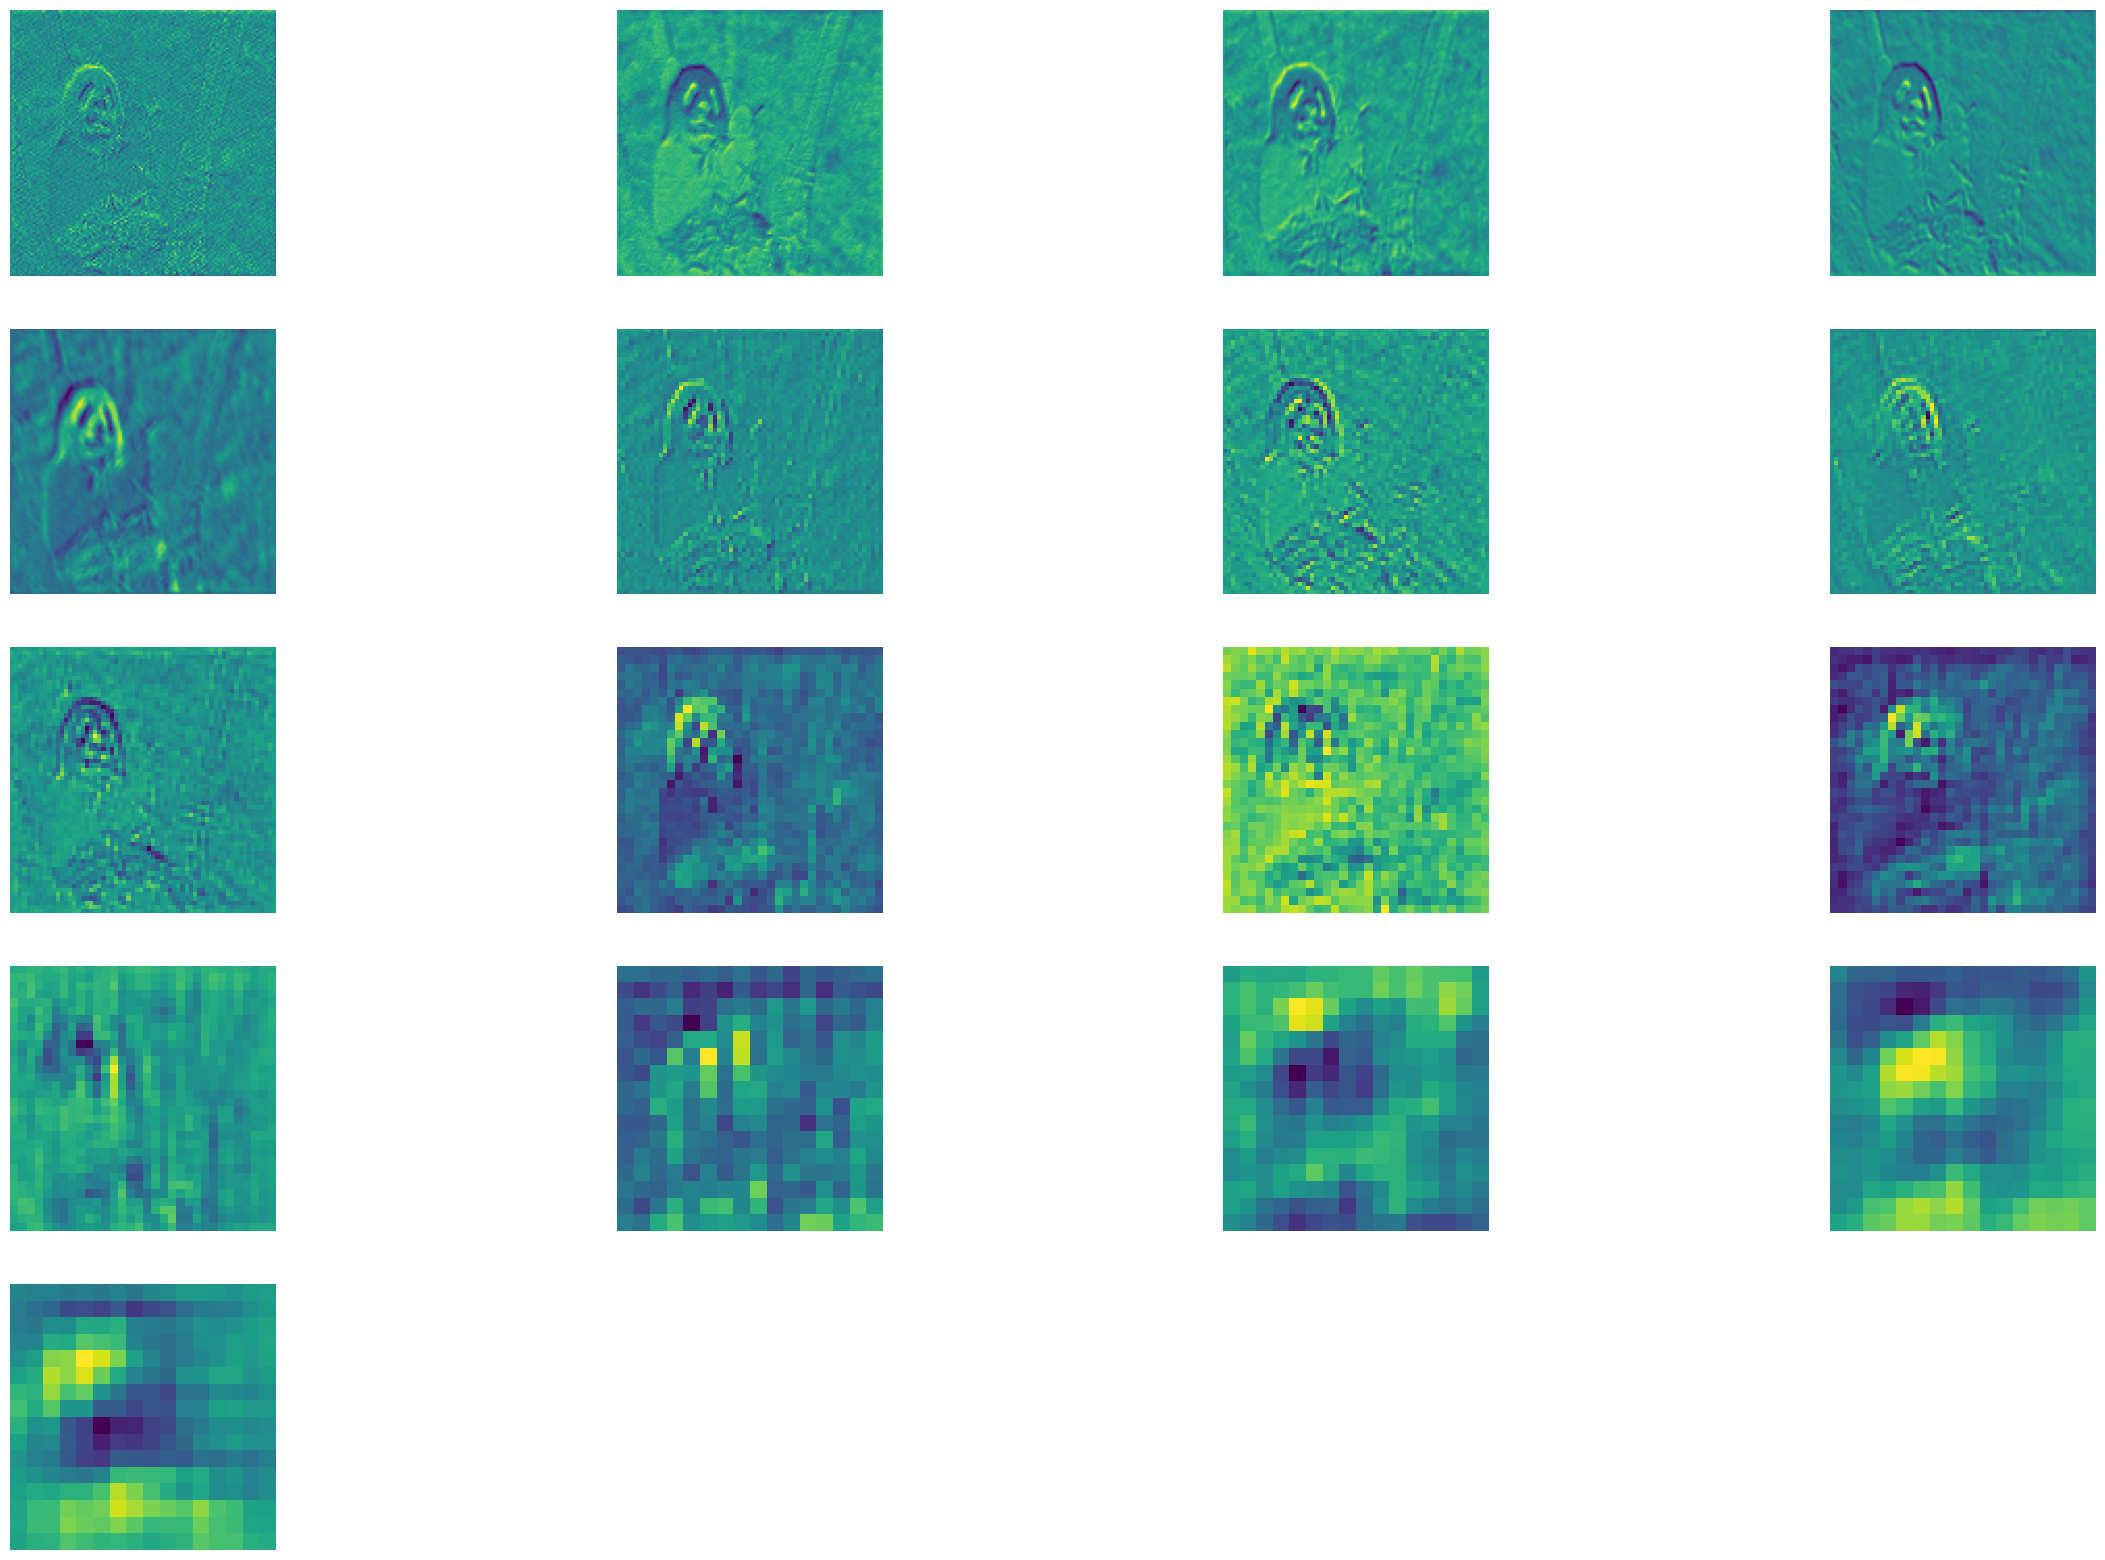

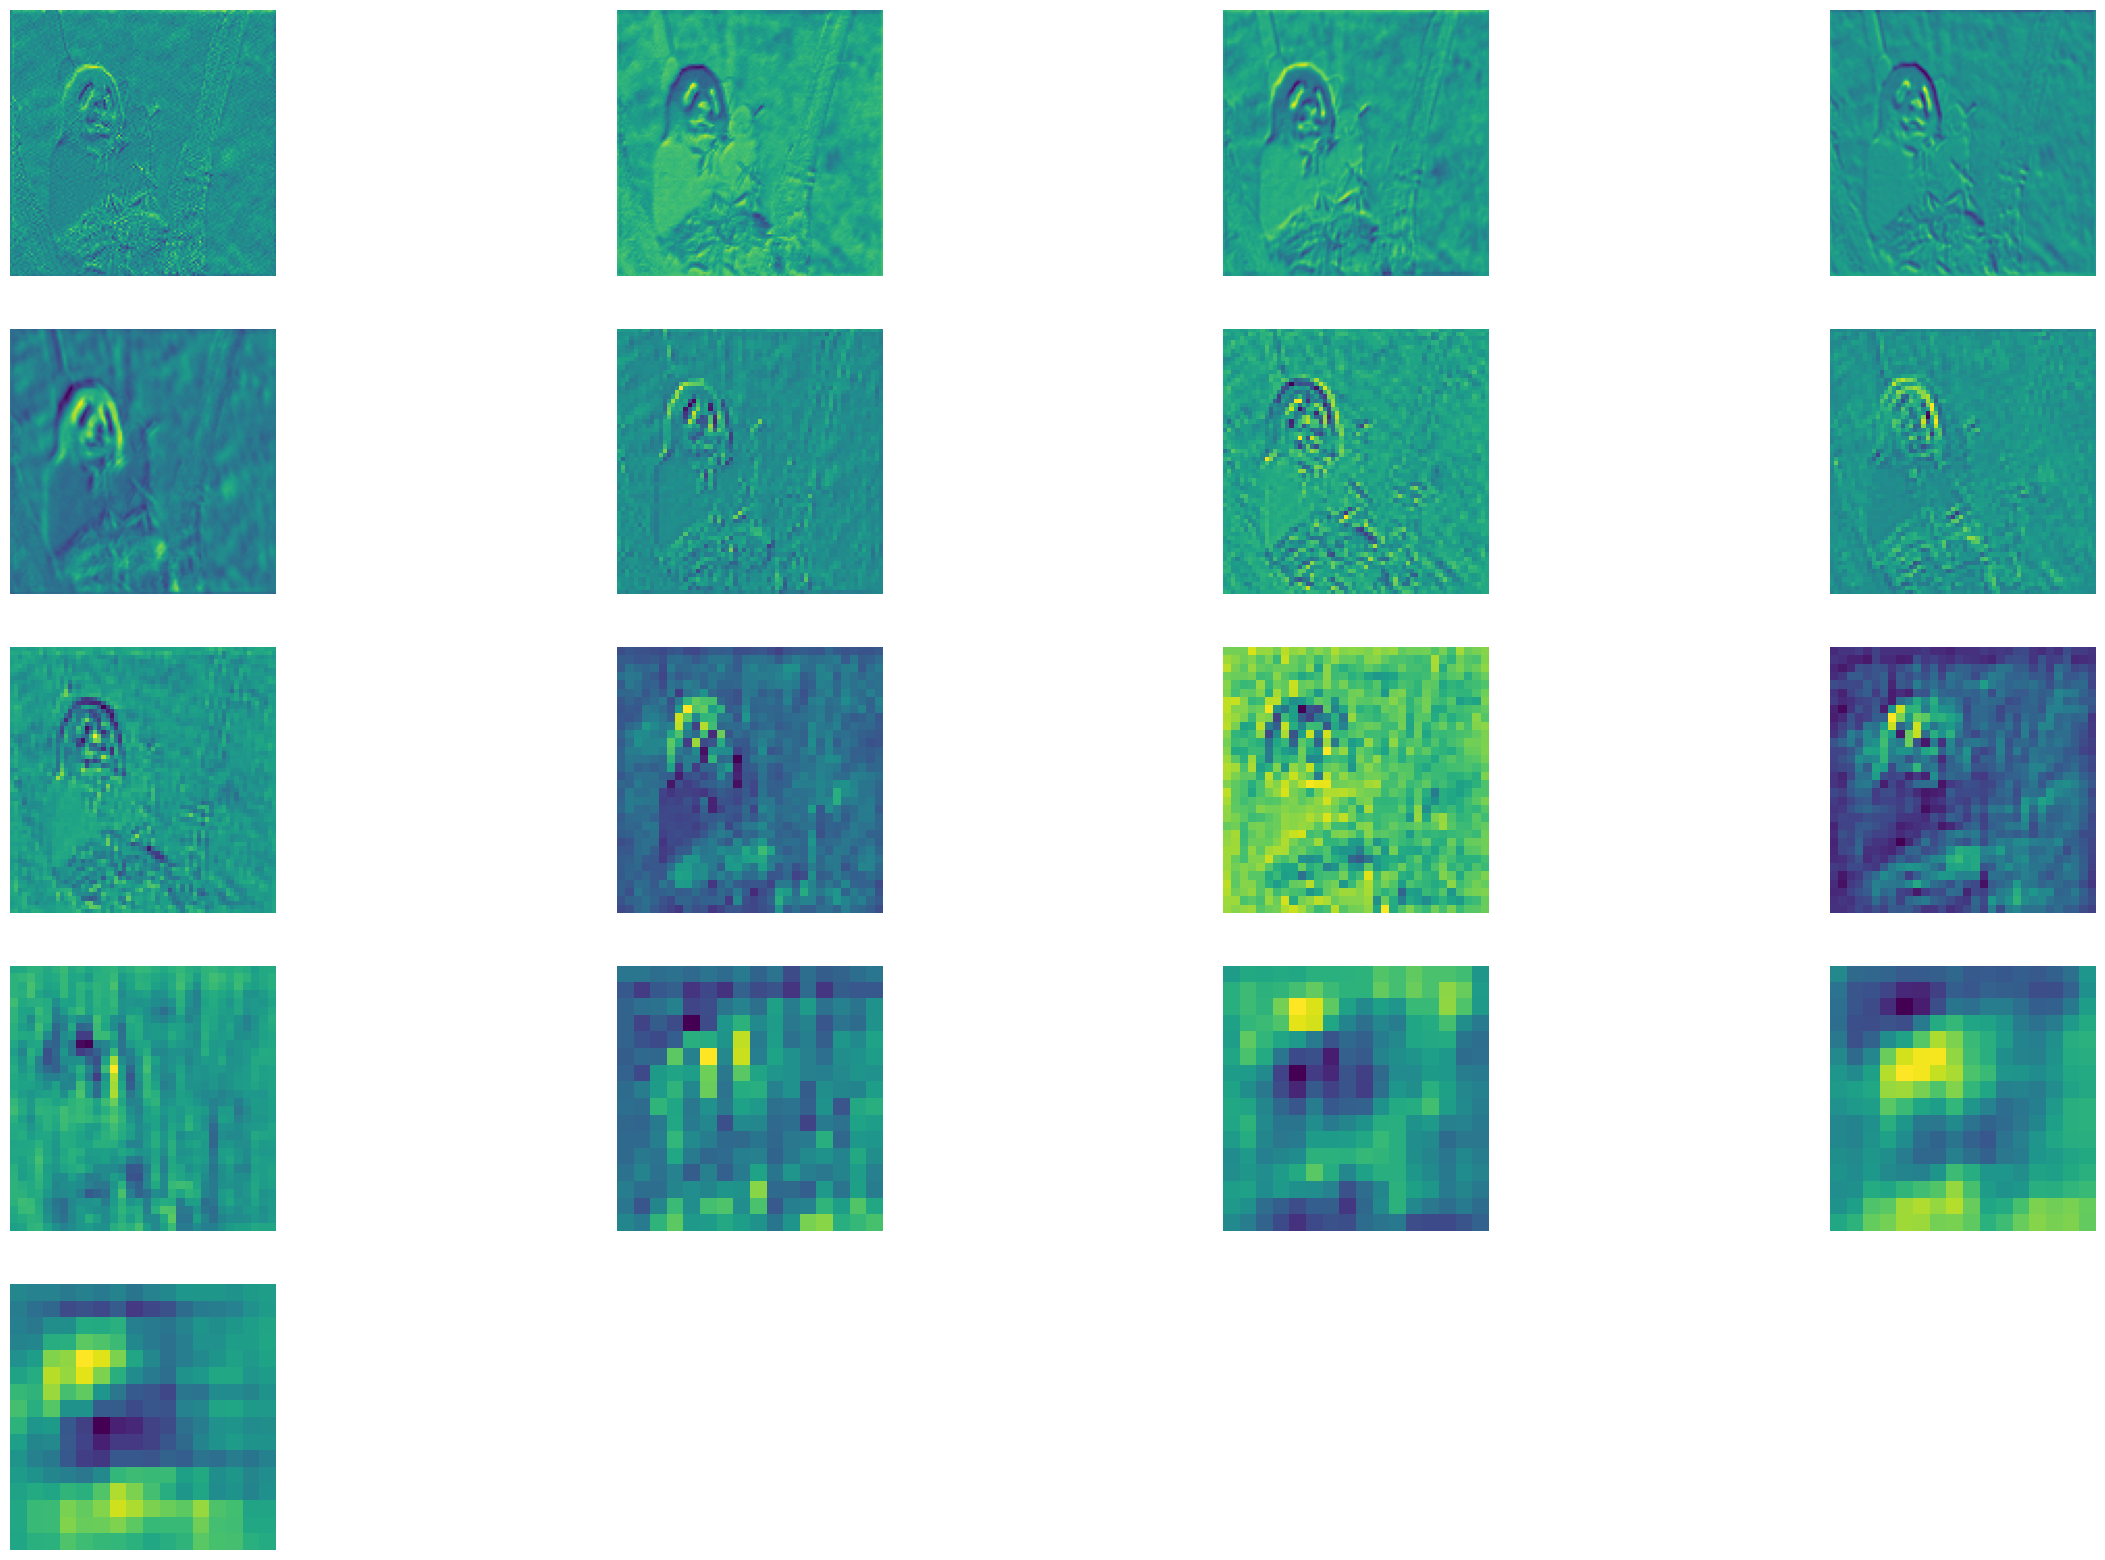

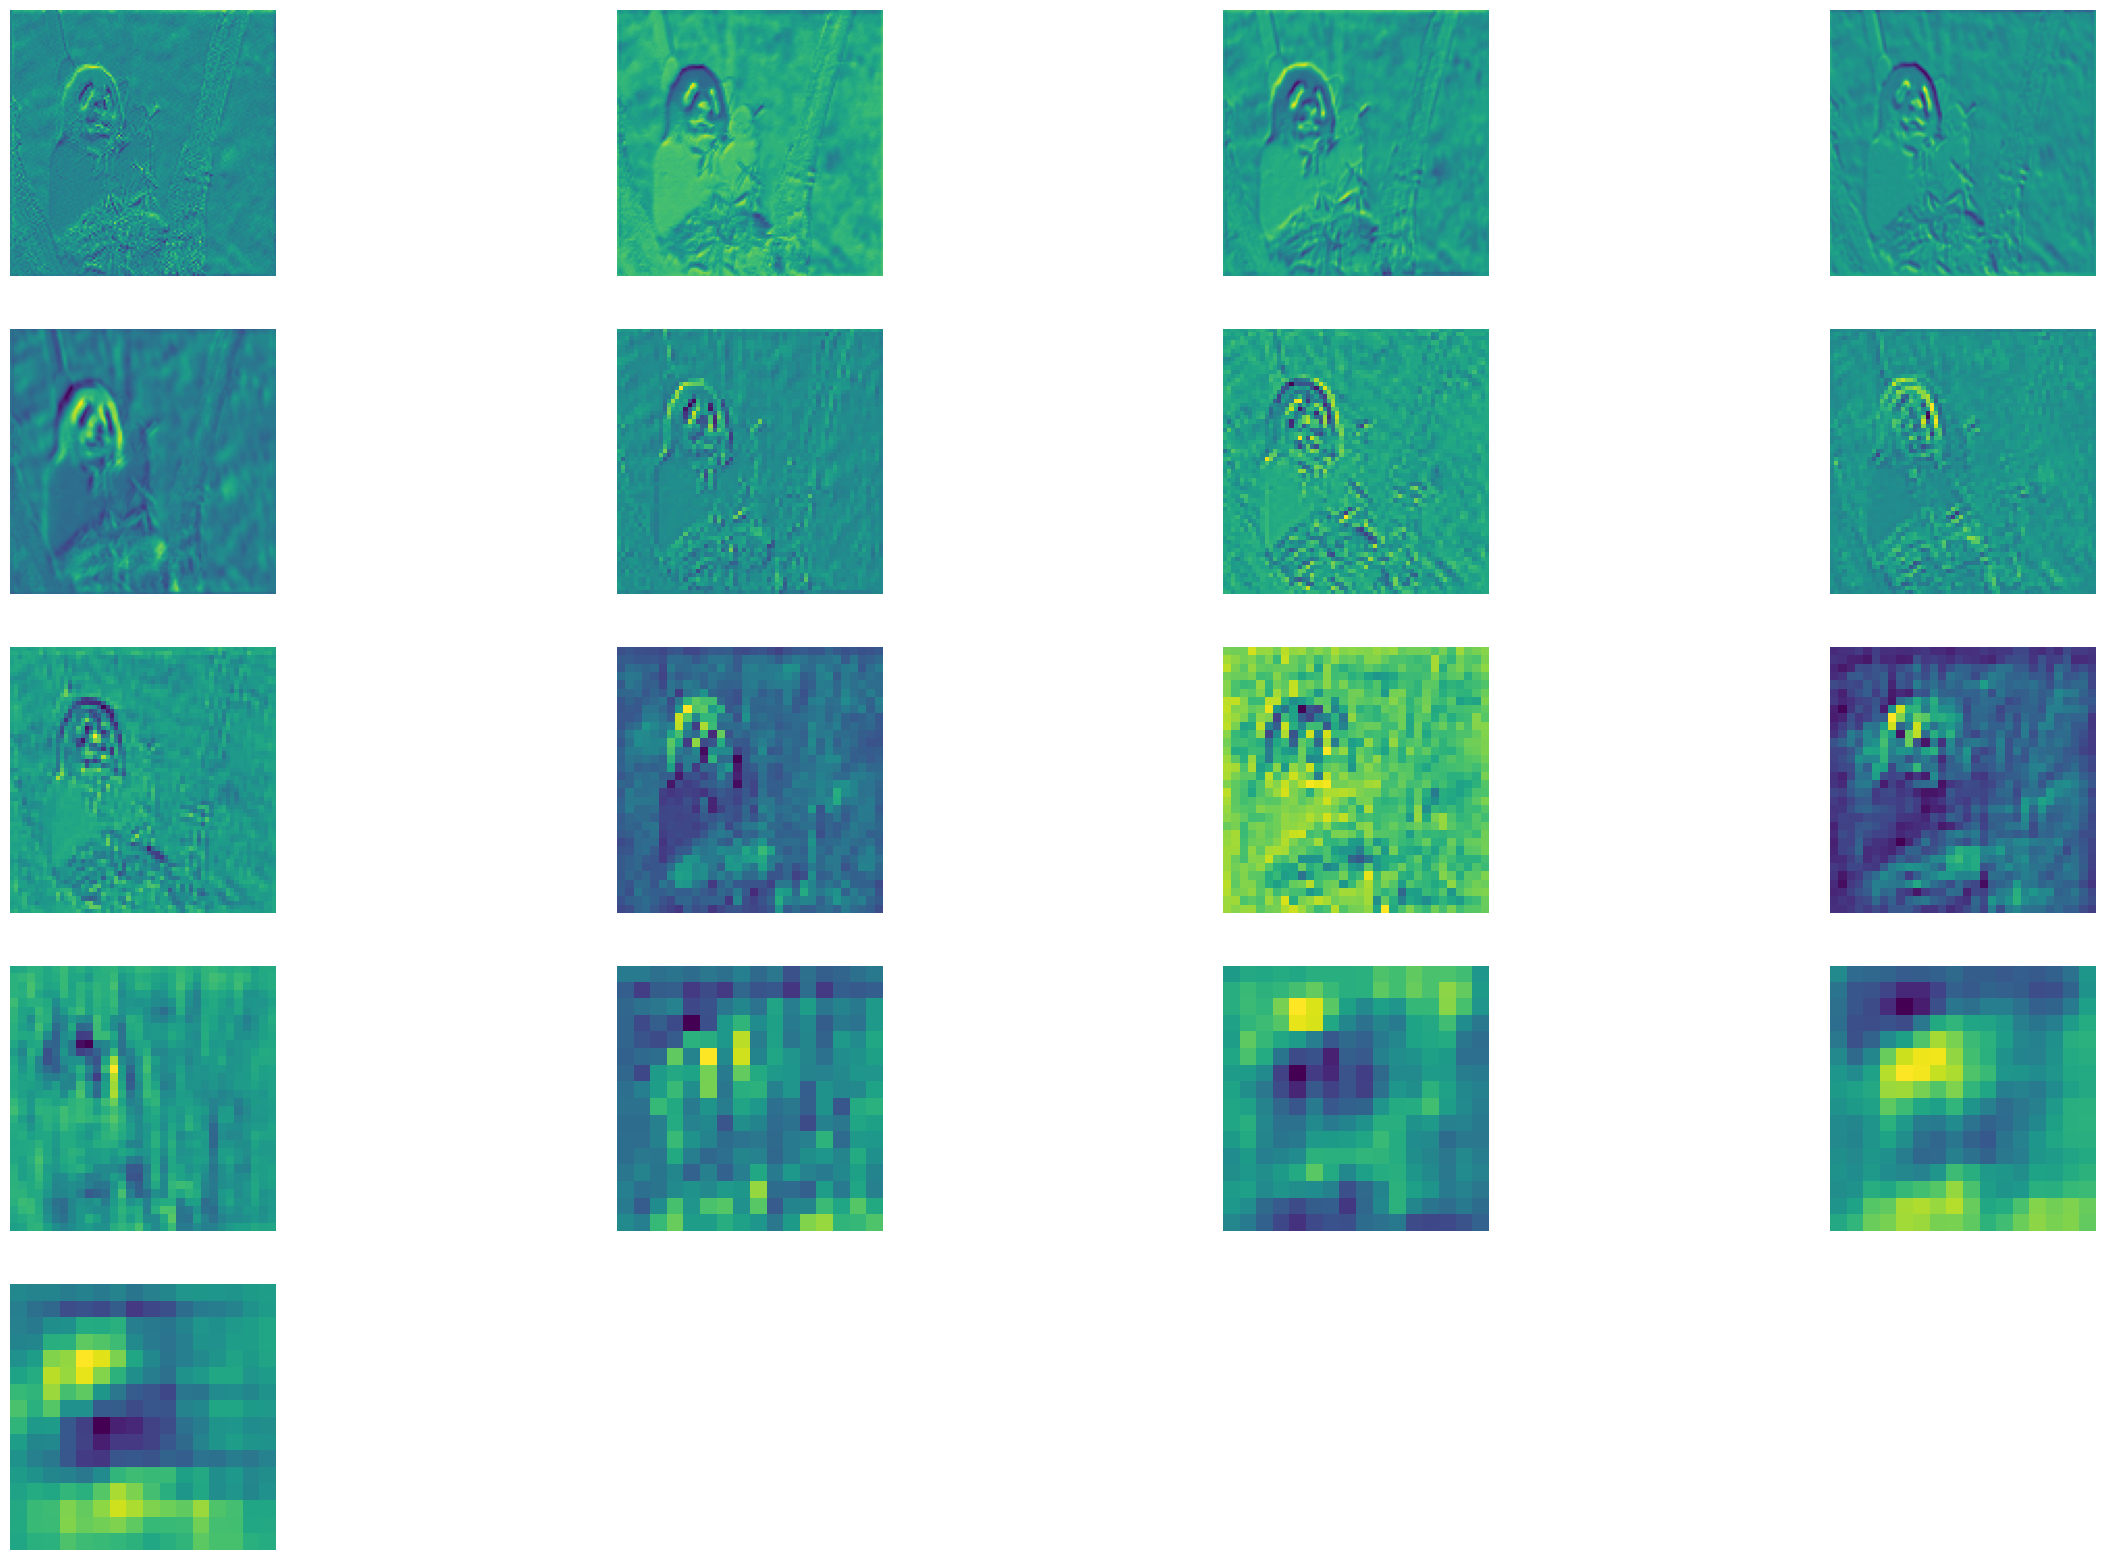

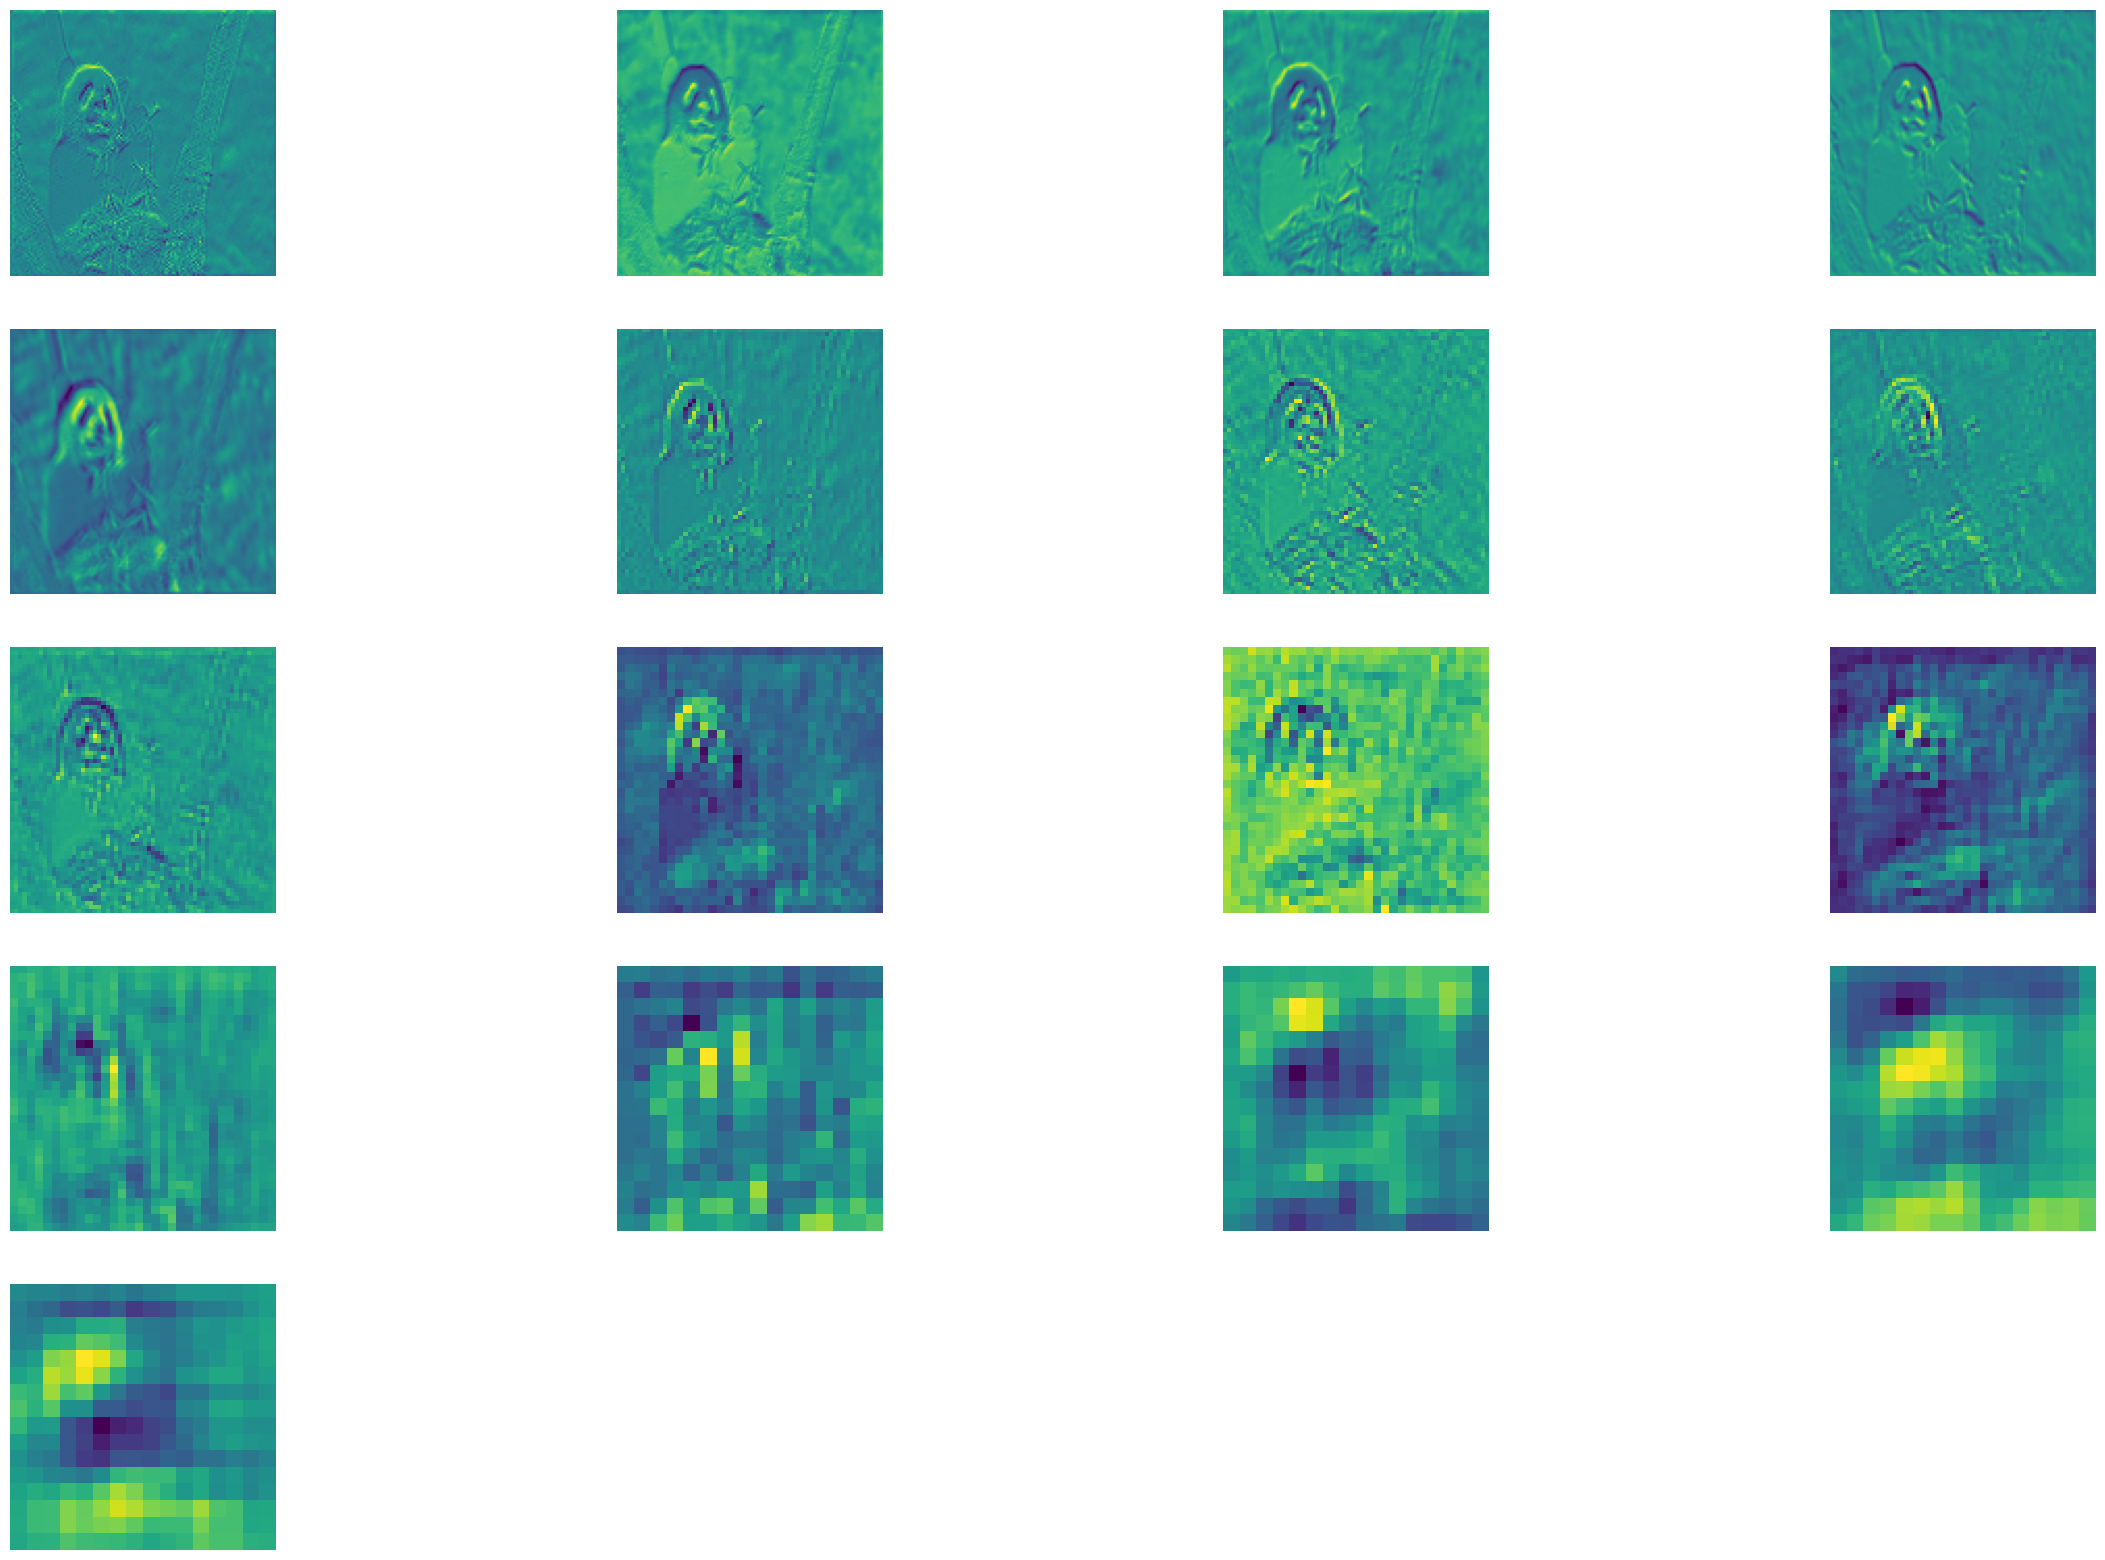

In [15]:
for img in adv_imgs:
    outputs  = get_activations(conv_layers=conv_layers, image=img)
    processed_feature_maps = summarize_channels(outputs=outputs)
    plot(processed_feature_maps)